<a href="https://colab.research.google.com/github/joshsbloom/swabseq/blob/master/kb/notebooks/comparison_v19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/joshsbloom/swabseq.git

Cloning into 'swabseq'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 925 (delta 94), reused 160 (delta 48), pack-reused 697
Receiving objects: 100% (925/925), 32.66 MiB | 25.60 MiB/s, done.
Resolving deltas: 100% (422/422), done.


# Install packages

In [2]:
!pip install anndata

     |████████████████████████████████| 122kB 2.8MB/s 


In [3]:
# Convert samplesheet to csv for loading
def samplesheet_to_csv(samplesheet, csv):
    with open(samplesheet, 'r') as ss, open(csv,'w') as c:
        line = ss.readline().strip()
        while line != '[Data]':
            line = ss.readline().strip()

        # the rest of the lines are data
        for line in ss:
          c.write(line)
samplesheet_to_csv("/content/swabseq/kb/data/v19/samplesheet.csv", "ss.csv")

In [4]:
!head ss.csv

Plate_ID,virus_identity,lysate,virus_copy,bc_set,Plate_384,Plate_384_quadrant,MasterMixVol,RT,SpikeCopies,RPP_strategy,Sample_Well,Sample_ID,index,index2
Plate1,U0052,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A01,Plate1-A01-1,GTGAGTCTGT,GCACTCAATT
Plate1,U0052,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A01,Plate1-A01-2,TCACCGCAAC,CCATGGTGAA
Plate1,N4078,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A02,Plate1-A02-1,CAGCATTGCA,CTTCTAGCAT
Plate1,N4078,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A02,Plate1-A02-2,TATGACAGCC,ATGCGTACAA
Plate1,U0069,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A03,Plate1-A03-1,GTTACATCGG,CGTTATCTCA
Plate1,U0069,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A03,Plate1-A03-2,ATGTTCTCAG,AGGCGGAGAT
Plate1,N4086,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A04,Plate1-A04-1,AACGTGACGC,TCG

# Python analysis

In [5]:
#@title Imports
import anndata
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec


def nd(arr):
  return np.asarray(arr).reshape(-1)

def yex(ax, offset=0):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, np.array(lims)+offset, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

#  Load data

In [6]:
adata = anndata.read_h5ad("/content/swabseq/kb/data/v19/matrix.h5ad")
adata.obs['index'] = adata.obs.index.str.slice(0, 10)
adata.obs['index2'] = adata.obs.index.str.slice(10)

In [7]:
ss = pd.read_csv('ss.csv')
ss['bcs'] = ss['index'] + ss['index2']
ss.index = ss['bcs']
print(ss.bcs.nunique())
samples = ss['Sample_ID'].values
index = ss['index'].values
index2 = ss['index2'].values

576


# Collapse the Rpp30 and S and S spike

In [8]:
data = adata[adata.obs.index.isin(ss.bcs.values)]
data = data[data.obs.sort_values("Sample_ID").index]

In [9]:
bcs_lst = data.obs.bcs.values.astype(str)

In [10]:
mtx = []
data.obs.groupby(["Plate_ID", "Sample_Well"]).apply(lambda x: mtx.append(nd(data.X[np.squeeze([np.where(bcs_lst == i)[0] for i in x.index.values] ) ].sum(axis=0))))
mtx = np.squeeze(mtx).astype(int)

In [11]:
mtx

array([[87381,  1312,     0,     0, 19049],
       [    1,  6700,     0,     0, 11392],
       [88092,    81,     0,     0,  4000],
       ...,
       [   18, 89766,     0,     0,  8734],
       [    3, 34805,     0,     0,  1264],
       [   16, 65127,     0,     0,   106]])

In [12]:
data.X.todense().astype(int)

matrix([[87380,  1312,     0,     0,     5],
        [    1,     0,     0,     0, 19044],
        [    1,  6698,     0,     0,     1],
        ...,
        [    0,     0,     0,     0,  1261],
        [   16, 65127,     0,     0,    14],
        [    0,     0,     0,     0,    92]])

In [13]:
obs = data.obs[~data.obs.Sample_ID.str.contains("-2").values]
var = data.var
ndata = anndata.AnnData(X=mtx, obs=obs, var=var)

In [105]:
ndata.obs['sample_id'] = ndata.obs.Plate_ID.astype(str) + "_" + ndata.obs.Sample_Well.astype(str)

# Load simple

In [55]:
def make_mtx(bcs, ecs, cnt, unique_ecs):
    
    bold = bcs[0]
    eold = ecs[0]
    cold = cnt[0]
    mtx = []
    
    d = defaultdict()
    #d[eold] = cold
    bold = 0
    for idx, b in enumerate(bcs):
    
        if b != bold and idx > 0:
            count = []
            for e in unique_ecs:
    
                count.append(d.get(e, 0))
            
            mtx.append(count)
            d = defaultdict()
    
        d[ecs[idx]] = cnt[idx]
    
        bold = b
    count = []
    for e in unique_ecs:
        count.append(d.get(e, 0))
    mtx.append(count)
    
    return np.asarray(mtx)

In [35]:
simple = pd.read_csv("swabseq/runs/v19/countTable.csv")
simple["sample_id"] = simple.Plate_ID + "_" + simple.Sample_Well

In [36]:
var = simple.amplicon.unique()
obs = simple.mergedIndex.unique()

In [59]:
df = simple.groupby(["sample_id","amplicon"])["Count"].sum().reset_index()

In [61]:
bcs = df.sample_id
var = df.amplicon
cnt = df.Count

unique_var = np.unique(var)

mtx = make_mtx(bcs, var, cnt, unique_var)

sm = anndata.AnnData(X=mtx.astype(int), obs = {"sample_id": df.drop_duplicates("sample_id").sample_id.values}, var = {"amplicon": unique_var})

In [90]:
sm.X = sm.X.astype(int)

# Do the actual comparison

In [91]:
sm

AnnData object with n_obs × n_vars = 288 × 3
    obs: 'sample_id'
    var: 'amplicon'

In [92]:
gene_map = {
    "S2": "S2",
    "S2_spikein": "S2_spike",
    "RPP30": "RPP30"
}

In [94]:
m = [True, True, False, False, True]
kb = ndata[:,m]

In [124]:
kb.var.index = kb.var.index.map(gene_map).values

In [106]:
kb_bcs = kb.obs.sample_id.values
sm_bcs = sm.obs.sample_id.values

common = np.intersect1d(kb_bcs, sm_bcs)

In [107]:
common.shape

(287,)

In [109]:
kb = kb[kb.obs.sample_id.isin(common).values]
sm = sm[sm.obs.sample_id.isin(common).values]

In [114]:
sm.var.sort_index().index

Index(['0', '1', '2'], dtype='object')

In [116]:
sm = sm[sm.obs.sort_values("sample_id").index]
sm = sm[:,sm.var.sort_index().index]

kb = kb[kb.obs.sort_values("sample_id").index]
kb = kb[:,kb.var.sort_index().index]

In [121]:
kb.obs.sample_id

barcode
ACGATGAGTCTCATGGTGGT    Plate11_A01
TAAGCGCTCACTTAGTCAGG    Plate11_A02
TTATCGTTGCCGATTCCTCG    Plate11_A03
TTCGCCACAGATGTTCTGAG    Plate11_A04
GGAGTTCTGCGTCGGCCATT    Plate11_A05
                           ...     
GTACCTTGGAGCACACTTCC     Plate1_H08
GTCAGCTTATACCTCCGACT     Plate1_H09
CCACGTTACGTTCTTCACGT     Plate1_H10
GACGAGTGGTCGAAGCGCAA     Plate1_H11
GCTATACCGCTGTTGCGAAT     Plate1_H12
Name: sample_id, Length: 287, dtype: object

In [122]:
sm.var

,amplicon
0,RPP30
1,S2
2,S2_spike


In [125]:
kb.var

""
RPP30
S2
S2_spike


In [126]:
g = ["RPP30",
"S2",
"S2_spike"]

In [129]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import matplotlib as mpl
from scipy import stats

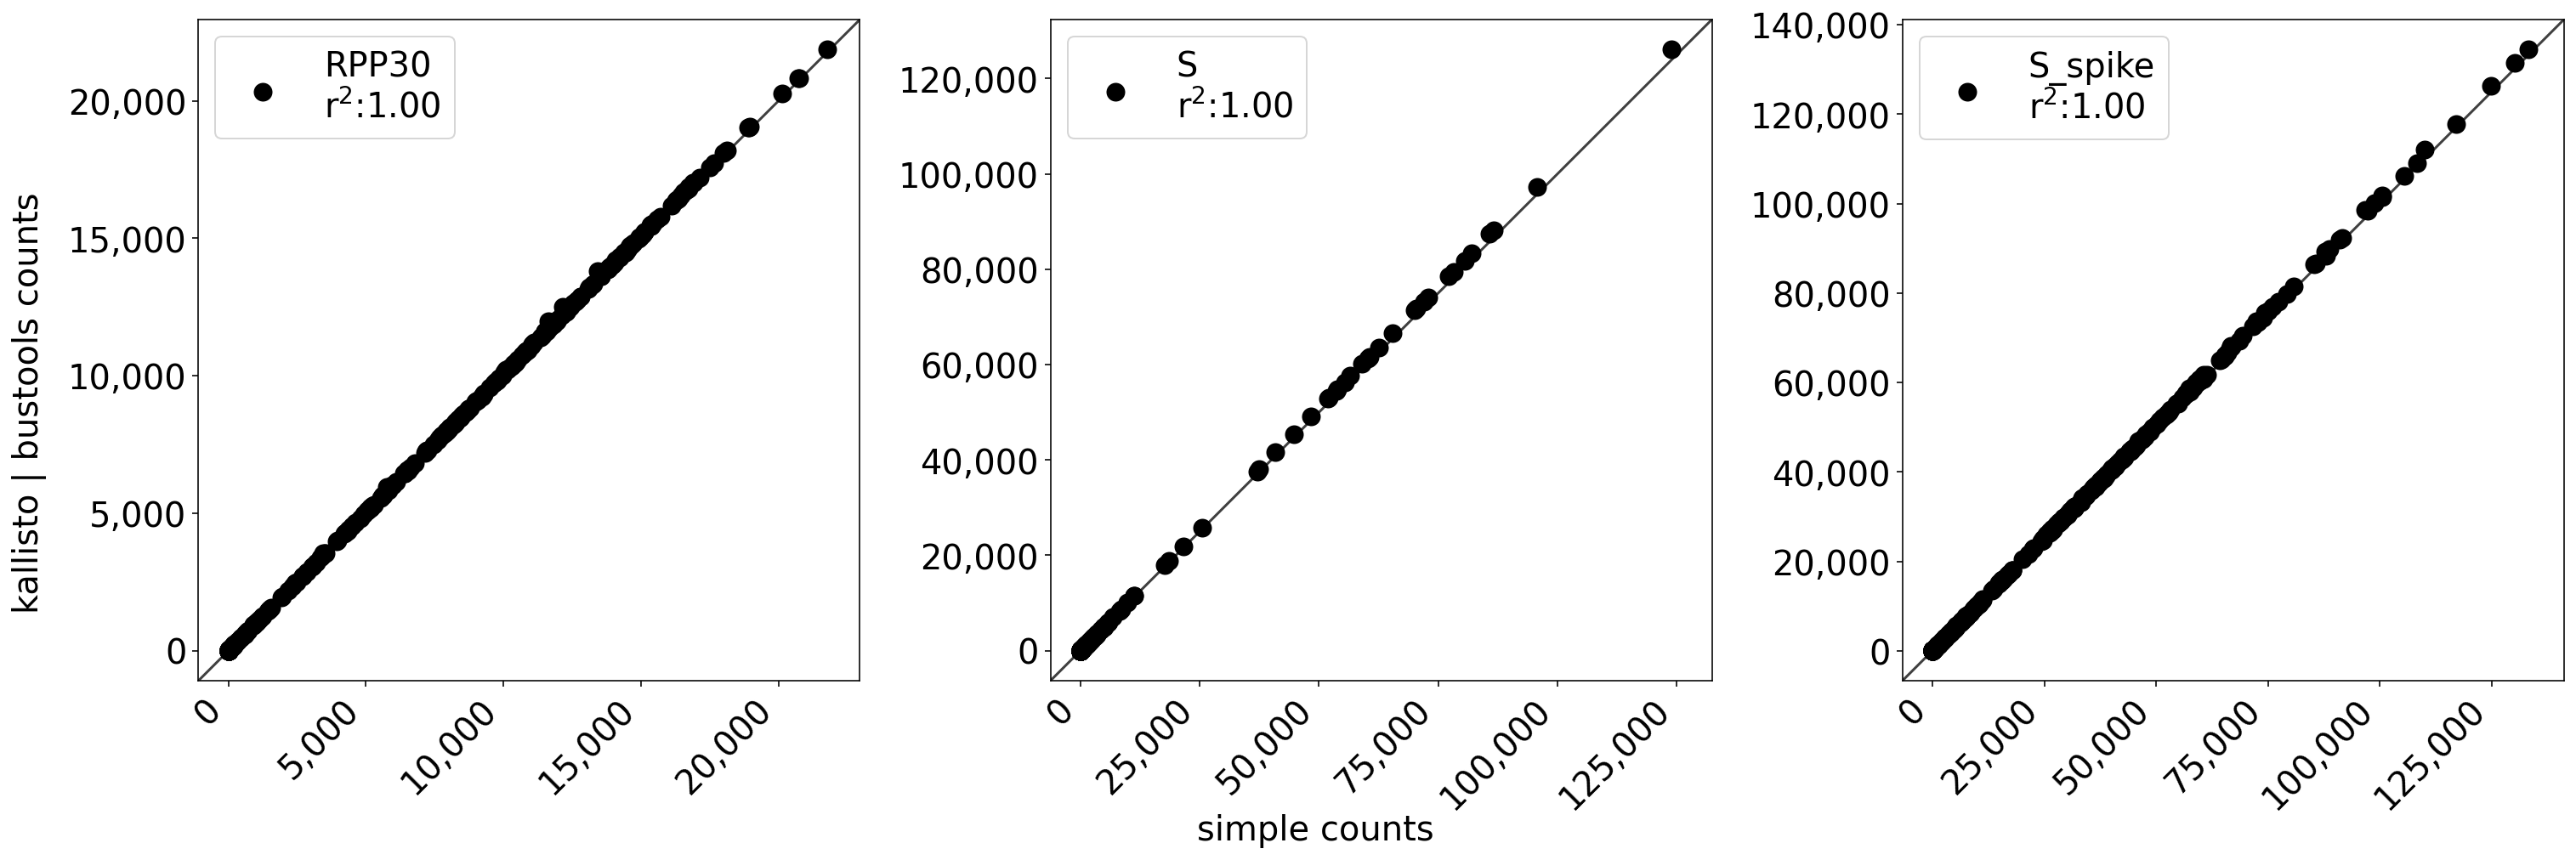

In [134]:
fig, ax = plt.subplots(figsize=(7*3,7), ncols=3)
axs = trim_axs(ax, len(kb.var.index.values))


for gidx, (ax, gene) in enumerate(zip(axs, g)):
    kb_gidx = np.where(kb.var.index.values==gene)[0][0]
    sm_gidx = np.where(sm.var.amplicon.values==gene)[0][0]
    x = nd(sm.X[:,sm_gidx])
    y = nd(kb.X[:,kb_gidx])
    #c = (y>250000).astype(int)
    
    r, p = stats.pearsonr(x, y)
    
    if gene=="S2":
        gene = "S"
    elif gene == "S2_spike":
        gene="S_spike"
    
    ax.scatter(x, y, color="k", s=100,  label="{}\nr$^2$:{:,.2f}".format(gene, r**2))
    
    yex(ax)
    #ax.set_axis_off()
    ax.legend(loc="upper left")

    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    for label in ax.get_xticklabels():
        label.set_ha("right")
        label.set_rotation(45)
fig.text(0.5, 0, 'simple counts', ha='center', va='center', fontsize=20)
fig.text(0, 0.5, 'kallisto | bustools counts', ha='center', va='center', rotation='vertical', fontsize=20)

plt.tight_layout()
#plt.savefig("./figs/kb_v_starcode.png",bbox_inches='tight', dpi=300)
plt.show()